In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/heart_disease_uci.csv')

# Data Cleaning

### Handle Inappropriate Zeros

In [3]:
cols = ['trestbps', 'chol']
df[cols] = df[cols].replace(0, np.nan)

### Fill in missing vaues

In [4]:
# for numeric columns: we use median values to fill (impute) missing values

numeric_columns = ['trestbps', 'chol', 'thalch', 'oldpeak']
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# for categoric values we use the most_frequent vaues to fill missing data
categorical_columns = ['fbs', 'restecg', 'exang', 'slope', 'thal']
categorical_imputer = SimpleImputer(strategy='most_frequent')

df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])


In [5]:
df.drop(['ca'], axis=1, inplace=True)

In [6]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
thal        0
num         0
dtype: int64

# Data Transform

### Label Encoding the Categorical Values


In [7]:
columns_to_encode = ['thal', 'dataset', 'slope', 'sex', 'num', 'cp', 'restecg','fbs', 'exang']

label_encoders = {}

for col in columns_to_encode:
  # create a new LabelEncoder
  le = LabelEncoder()

  # fit and transform the data
  df[col] = le.fit_transform(df[col])

  # store the encoder for later
  label_encoders[col] = le

### Transform the numeric *columns*

In [8]:
columns_to_scale = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']
min_max_scalers = {}

for col in columns_to_scale:
  scaler = MinMaxScaler()

  df[col] = scaler.fit_transform(df[[col]])

  min_max_scalers[col] = scaler

## Select only necessary values

In [9]:
X = df.drop(['id','num'], axis = 1)

In [20]:
y_binary = df['num']

In [21]:
y_binary = y_binary.replace(2, 1)
y_binary = y_binary.replace(3, 1)
y_binary = y_binary.replace(4, 1)

## Splitting Data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, train_size=0.8, random_state=42)

# Train an ML classifier

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Train a model

In [65]:
model = RandomForestClassifier(random_state=42)

In [66]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
y_pred = model.predict(X_test)

In [68]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of our Random Forest model: ', accuracy)

Accuracy of our Random Forest model:  0.8206521739130435


## Let's tune the hyper-parameters

In [95]:
# perform grid search

model = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth' : [None, 5, 10],
    'n_estimators': [None, 10, 100, 1000],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4]
}

# not showing output here for ease of reading.
# when practicing, you can set the verbose parameter like verbose=10 in the line below
# to see how gridsearch is going
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
555 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [None, 1, 2, 4],
                         'min_samples_split': [None, 2, 5, 10],
                         'n_estimators': [None, 10, 100, 1000]})

In [96]:
# get best score so far
best_score = grid_search.best_score_

print('Best score: ', best_score)

Best score:  0.8152141937856223


In [97]:
best_params = grid_search.best_params_

print('Best params: ', best_params)

Best params:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [98]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Tuned accuracy: ', accuracy)

Tuned accuracy:  0.8315217391304348


## Evaluate their performances

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80        81
           1       0.83      0.87      0.85       103

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



<Axes: >

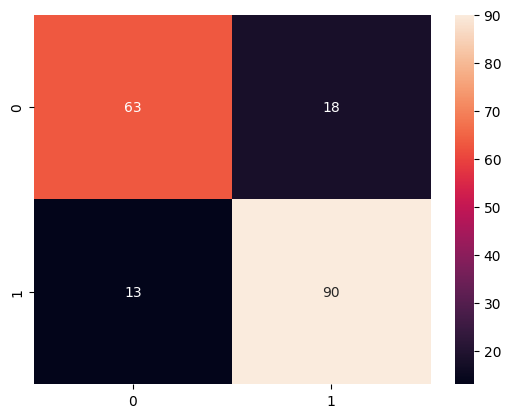

In [100]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

# Model Selection

In [101]:
models = [
    {
      'name': 'Random Forest',
      'model': RandomForestClassifier(random_state=42),
    },
    {
      'name': 'Logistic Regression',
      'model': LogisticRegression(random_state=42),
    },
    {
      'name': 'KNN',
      'model': KNeighborsClassifier(),
    },
    {
      'name': 'XG Boost',
      'model': XGBClassifier(random_state=42),
    },
    {
      'name': 'Support Vector Machine',
      'model': SVC(random_state=42),
    }

]

In [102]:
best_model = None
best_accuracy = 0.0

In [103]:
for model_dict in models:
  pipeline = Pipeline([
      ('model', model_dict['model'])
  ])

  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  print('Model', model_dict['name'])
  print('Test Accuracy', accuracy)
  print()

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = pipeline

print('Best Model', best_model)


Model Random Forest
Test Accuracy 0.8206521739130435

Model Logistic Regression
Test Accuracy 0.8369565217391305

Model KNN
Test Accuracy 0.8478260869565217

Model XG Boost
Test Accuracy 0.8152173913043478

Model Support Vector Machine
Test Accuracy 0.8043478260869565

Best Model Pipeline(steps=[('model', KNeighborsClassifier())])


In [104]:
# evaluate and print Confusion Matrix for best model

In [105]:
# integrate grid search